### Mean Absolute Deviation
---

Realized volatility puts a large weight on changes in log returns and increases the impact of outliers on the computed metric. The estimator might not be robust and it might be preferrable to rely on a realised volatility defined as a $L^1$ norm.

It is defined as the mean absolute deviation.

\begin{equation}
{MAD}(t_i) = \frac{\sum_{i=1}^n |(r(t_i) - \mu)|}{n - 1}
\end{equation}

### Annualization
---

In [1]:
# ----
# TODO
# ----

# Check wether we can assume the MAD is increasing with time horizon (Gaussian property not true anymore in L1).

Annualization is performed the same way as the realized volatility:

\begin{equation}
MAD_{ann} = \sqrt{\frac{1year}{\Delta t}}MAD
\end{equation}

### Implementation
---

In [2]:
import sys
sys.path.insert(0,'/home/ec2-user/SageMaker/core/analytics')
from utils import clamp

import numpy as np


class MeanAbsoluteDeviation:
    """
    Inline mean absolute deviation model.
    """
    def __init__(self, delta_t: int, n: int = 12, cap: float = 3.5, floor: float = 0.10):
        """
        Parameters
        ----------
        delta_t: int
            The time interval in seconds used to compute returns.
        n: int
            The number of return observations used to compute volatility estimate.
        cap: float 
            Upper bound on realized volatility value.
        floor: float
            Lower bound on realized volatility value.
        """
        self.delta_t = delta_t
        self.n = n
        self.cap = cap
        self.floor = floor
        
        self.returns = []
        self.previous_ts = None
        self.previous_price = None
        self.mean = 0.0
        
        self.SECONDS_PER_YEAR = 365.25 * 24 * 60 * 60
        
        
    def update(self, ts: int, price: float):
        """
        Upates state of the predictor given a new price coming in.
        Timestamps are assumed to be given in milliseconds.
        """
        # Initial run
        if self.previous_price is None:
            self.previous_ts = ts
            self.previous_price = price
            return
        
        # Compute returns (timestamps are assumed in milliseconds)
        if (ts - self.previous_ts) / 1000 < self.delta_t:
            return
        else:
            log_return = np.log(price/self.previous_price)
            self.returns.append(log_return)
            self.previous_ts = ts
            self.previous_price = price
            
        # Update lookback window
        if len(self.returns) > self.n:
            self.returns.pop(0)
            
        # Update mean
        self.mean = np.mean(self.returns)
        
        
    def predict(self):
        """
        Returns realized volatility value.
        """
        # Check wether we have some updated information 
        if len(self.returns) < self.n: 
            return np.nan
        
        # Compute realized volatility
        mad = np.array([np.abs(x - self.mean) for x in self.returns]).sum()
        mad = mad / (self.n - 1)
        
        # Annualize
        # TODO: Check if we can annualize a MAD metric
        mad = np.sqrt(self.SECONDS_PER_YEAR / self.delta_t) * mad 
        
        # Return
        return clamp(mad, self.floor, self.cap) 

### Study
---

In [3]:
import time
import sys 

import matplotlib.pyplot as plt
import pandas as pd

In [4]:
sys.path.insert(0,'/home/ec2-user/SageMaker/core/loaders')
from ch_kaikopublictrades import KaikoTradeLoader

In [5]:
exchange = 'huobi'
symbol = 'ethusdt'
start_date = '2022-03-01 00:00:00'
end_date = '2022-03-01 23:59:59'
interval = ' 1 SECOND '
tick = 0.01
tz = 'UTC'

tl = KaikoTradeLoader(tz)

In [6]:
start_time = time.perf_counter()
public_trades = tl.get_public_trades(exchange, symbol, start_date, end_date)
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:0.4f} seconds")

Time elapsed: 6.5069 seconds


In [7]:
mad = MeanAbsoluteDeviation(delta_t = 300, n = 12, floor = 0.0, cap = 5.0)
lst_mad = []

for _, row in public_trades.iterrows():
    mad.update(row['ts'], row['price'])
    lst_mad.append(mad.predict())
    
ser_mad = pd.Series(lst_mad, index=pd.to_datetime(public_trades.ts, unit = 'ms'))
public_trades.index = pd.to_datetime(public_trades.ts, unit='ms')

<AxesSubplot:xlabel='ts', ylabel='Price'>

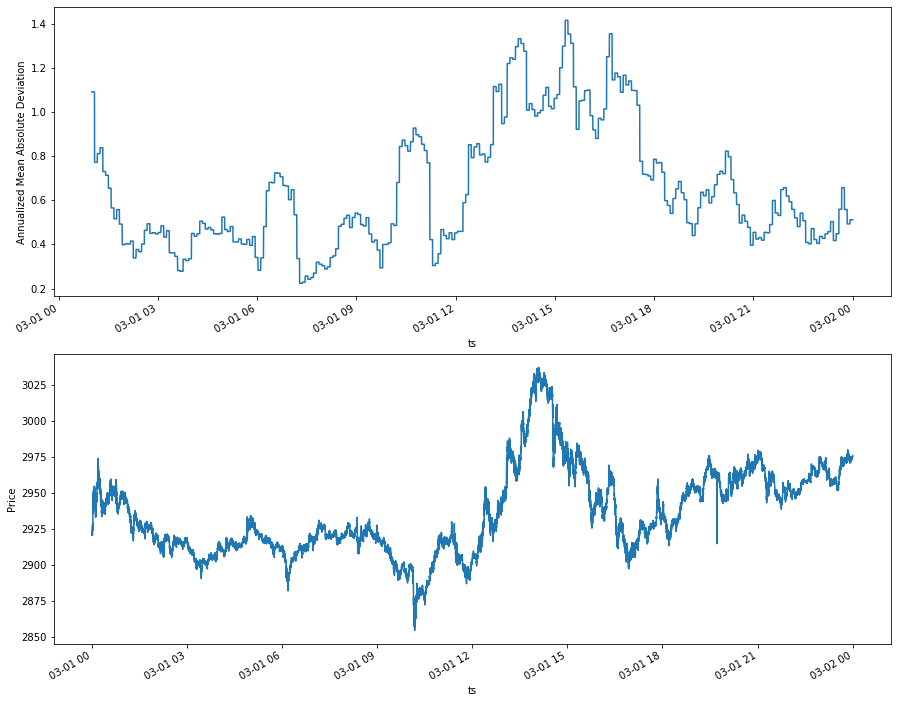

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15,13))
axs[0].set_ylabel('Annualized Mean Absolute Deviation')
axs[1].set_ylabel('Price')
ser_mad.plot(ax=axs[0])
public_trades.price.plot(ax=axs[1])